In [33]:
from pathlib import Path
import paths as pt
matplotlib_style = 'default' # fivethirtyeight
import matplotlib.pyplot as plt
plt.style.use(matplotlib_style)
import pandas as pd

#import seaborn as sns
#sns.set_theme()

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

results = pd.read_csv(Path.joinpath(pt.RESULTS_DIR, f"neural_training_results.csv"))

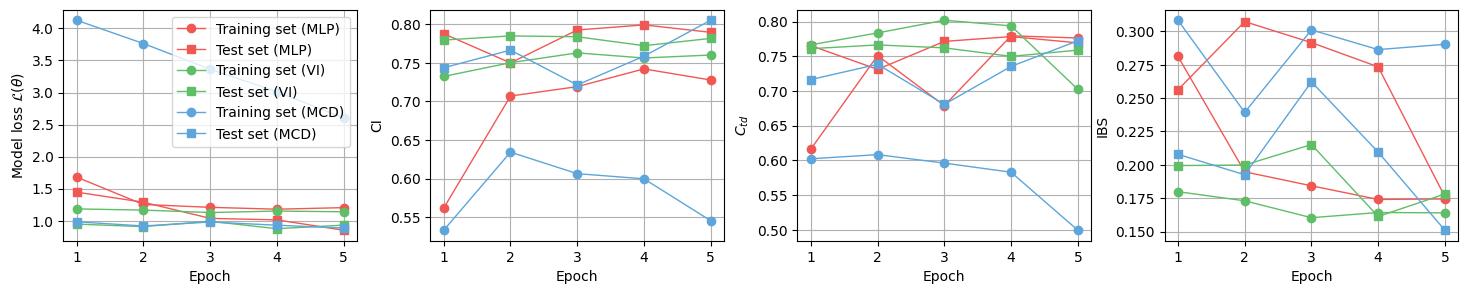

In [34]:
dataset_name = "WHAS500"
n_epochs = max(results.loc[results['ModelName'] == "MLP"].index) + 1

mlp_results = results.loc[(results['DatasetName'] == dataset_name) & (results['ModelName'] == "MLP")]
vi_results = results.loc[(results['DatasetName'] == dataset_name) & (results['ModelName'] == "VI")]
mc_results = results.loc[(results['DatasetName'] == dataset_name) & (results['ModelName'] == "MCD")]
mlp_train_loss = mlp_results[['TrainLoss']]
mlp_train_ci = mlp_results[['TrainCI']]
mlp_train_ctd = mlp_results[['TrainCTD']]
mlp_train_ibs = mlp_results[['TrainIBS']]
mlp_test_loss = mlp_results[['TestLoss']]
mlp_test_ci = mlp_results[['TestCI']]
mlp_test_ctd = mlp_results[['TestCTD']]
mlp_test_ibs = mlp_results[['TestIBS']]

vi_train_loss = vi_results[['TrainLoss']]
vi_train_ci = vi_results[['TrainCI']]
vi_train_ctd = vi_results[['TrainCTD']]
vi_train_ibs = vi_results[['TrainIBS']]
vi_test_loss = vi_results[['TestLoss']]
vi_test_ci = vi_results[['TestCI']]
vi_test_ctd = vi_results[['TestCTD']]
vi_test_ibs = vi_results[['TestIBS']]

mc_train_loss = mc_results[['TrainLoss']]
mc_train_ci = mc_results[['TrainCI']]
mc_train_ctd = mc_results[['TrainCTD']]
mc_train_ibs = mc_results[['TrainIBS']]
mc_test_loss = mc_results[['TestLoss']]
mc_test_ci = mc_results[['TestCI']]
mc_test_ctd = mc_results[['TestCTD']]
mc_test_ibs = mc_results[['TestIBS']]

epochs = range(1, n_epochs+1)
fig, axs = plt.subplots(1, 4, figsize=(18, 3))
axs[0].plot(epochs, mlp_train_loss, label='Training set (MLP)', marker="o", color=TFColor[0], linewidth=1)
axs[0].plot(epochs, mlp_test_loss, label='Test set (MLP)', marker="s", color=TFColor[0], linewidth=1)
axs[0].plot(epochs, vi_train_loss, label='Training set (VI)', marker="o", color=TFColor[2], linewidth=1)
axs[0].plot(epochs, vi_test_loss, label='Test set (VI)', marker="s", color=TFColor[2], linewidth=1)
axs[0].plot(epochs, mc_train_loss, label='Training set (MCD)', marker="o", color=TFColor[3], linewidth=1)
axs[0].plot(epochs, mc_test_loss, label='Test set (MCD)', marker="s", color=TFColor[3], linewidth=1)
axs[0].legend(loc='upper right')
axs[0].grid(visible=True)
axs[0].set_xlabel('Epoch', fontsize="medium")
axs[0].set_ylabel(r'Model loss $\mathcal{L}(\theta)$', fontsize="medium")

axs[1].plot(epochs, mlp_train_ci, marker="o", color=TFColor[0], linewidth=1)
axs[1].plot(epochs, mlp_test_ci, marker="s", color=TFColor[0], linewidth=1)
axs[1].plot(epochs, vi_train_ci, marker="o", color=TFColor[2], linewidth=1)
axs[1].plot(epochs, vi_test_ci, marker="s", color=TFColor[2], linewidth=1)
axs[1].plot(epochs, mc_train_ci, marker="o", color=TFColor[3], linewidth=1)
axs[1].plot(epochs, mc_test_ci, marker="s", color=TFColor[3], linewidth=1)
axs[1].grid(visible=True)
axs[1].set_xlabel('Epoch', fontsize="medium")
axs[1].set_ylabel('CI', fontsize="medium")

axs[2].plot(epochs, mlp_train_ctd, marker="o", color=TFColor[0], linewidth=1)
axs[2].plot(epochs, mlp_test_ctd, marker="s", color=TFColor[0], linewidth=1)
axs[2].plot(epochs, vi_train_ctd, marker="o", color=TFColor[2], linewidth=1)
axs[2].plot(epochs, vi_test_ctd, marker="s", color=TFColor[2], linewidth=1)
axs[2].plot(epochs, mc_train_ctd, marker="o", color=TFColor[3], linewidth=1)
axs[2].plot(epochs, mc_test_ctd, marker="s", color=TFColor[3], linewidth=1)
axs[2].grid(visible=True)
axs[2].set_xlabel('Epoch', fontsize="medium")
axs[2].set_ylabel('$C_{td}$', fontsize="medium")

axs[3].plot(epochs, mlp_train_ibs, marker="o", color=TFColor[0], linewidth=1)
axs[3].plot(epochs, mlp_test_ibs, marker="s", color=TFColor[0], linewidth=1)
axs[3].plot(epochs, vi_train_ibs, marker="o", color=TFColor[2], linewidth=1)
axs[3].plot(epochs, vi_test_ibs, marker="s", color=TFColor[2], linewidth=1)
axs[3].plot(epochs, mc_train_ibs, marker="o", color=TFColor[3], linewidth=1)
axs[3].plot(epochs, mc_test_ibs, marker="s", color=TFColor[3], linewidth=1)
axs[3].grid(visible=True)
axs[3].set_xlabel('Epoch', fontsize="medium")
axs[3].set_ylabel('IBS', fontsize="medium")

plt.subplots_adjust(wspace=0.25)

fig.savefig(Path.joinpath(pt.RESULTS_DIR, f"{dataset_name.lower()}_training_curves.pdf"),
            format='pdf', bbox_inches="tight")

In [35]:
epochs = range(1, N_EPOCHS+1)
fig, axs = plt.subplots(1, 4, figsize=(18, 3))
axs[0].plot(epochs, baseline_loss, label='Baseline')
axs[0].plot(epochs, mc_loss, label='MC')
axs[0].legend(loc="upper right")
axs[0].set(xlabel='Epoch', ylabel=r'Model loss $\mathcal{L}(\theta)$')
axs[1].plot(epochs, baseline_ci, label='MLP')
axs[1].plot(epochs, mc_ci, label='MC')
axs[1].set(xlabel='Epoch', ylabel='C-Index')
axs[2].plot(epochs, baseline_ctd, label='MLP')
axs[2].plot(epochs, mc_ctd, label='MC')
axs[2].set(xlabel='Epoch', ylabel='$C_{td}$')
axs[3].plot(epochs, baseline_ibs, label='MLP')
axs[3].plot(epochs, mc_ibs, label='MC')
axs[3].set(xlabel='Epoch', ylabel='IBS')
fig.savefig(Path.joinpath(pt.RESULTS_DIR, "loss.pdf"),
            format='pdf', bbox_inches="tight")

NameError: name 'N_EPOCHS' is not defined